First preparing the lables from xml to txt

In [ ]:
import os
import xml.etree.ElementTree as ET

classes = [ 'rice leaf roller', 'rice leaf caterpillar', 'paddy stem maggot', 'asiatic rice borer', 'yellow rice borer',
    'rice gall midge', 'Rice Stemfly', 'brown plant hopper', 'white backed plant hopper', 'small brown plant hopper',
    'rice water weevil', 'rice leafhopper', 'grain spreader thrips', 'rice shell pest', 'grub', 'mole cricket',
    'wireworm', 'white margined moth', 'black cutworm', 'large cutworm', 'yellow cutworm', 'red spider', 'corn borer',
    'army worm', 'aphids', 'Potosiabre vitarsis', 'peach borer', 'english grain aphid', 'green bug',
    'bird cherry-oataphid', 'wheat blossom midge', 'penthaleus major', 'longlegged spider mite',
    'wheat phloeothrips', 'wheat sawfly', 'cerodonta denticornis', 'beet fly', 'flea beetle', 'cabbage army worm',
    'beet army worm', 'Beet spot flies', 'meadow moth', 'beet weevil', 'sericaorient alismots chulsky', 'alfalfa weevil',
    'flax budworm', 'alfalfa plant bug', 'tarnished plant bug', 'Locustoidea', 'lytta polita', 'legume blister beetle',
    'blister beetle', 'therioaphis maculata Buckton', 'odontothrips loti', 'Thrips', 'alfalfa seed chalcid',
    'Pieris canidia', 'Apolygus lucorum', 'Limacodidae', 'Viteus vitifoliae', 'Colomerus vitis',
    'Brevipoalpus lewisi McGregor', 'oides decempunctata', 'Polyphagotars onemus latus', 'Pseudococcus comstocki Kuwana',
    'parathrene regalis', 'Ampelophaga', 'Lycorma delicatula', 'Xylotrechus', 'Cicadella viridis', 'Miridae',
    'Trialeurodes vaporariorum', 'Erythroneura apicalis', 'Papilio xuthus', 'Panonchus citri McGregor',
    'Phyllocoptes oleiverus ashmead', 'Icerya purchasi Maskell', 'Unaspis yanonensis', 'Ceroplastes rubens',
    'Chrysomphalus aonidum', 'Parlatoria zizyphus Lucus', 'Nipaecoccus vastalor', 'Aleurocanthus spiniferus',
    'Tetradacus c Bactrocera minax', 'Dacus dorsalis(Hendel)', 'Bactrocera tsuneonis', 'Prodenia litura',
    'Adristyrannus', 'Phyllocnistis citrella Stainton', 'Toxoptera citricidus', 'Toxoptera aurantii',
    'Aphis citricola Vander Goot', 'Scirtothrips dorsalis Hood', 'Dasineura sp', 'Lawana imitata Melichar',
    'Salurnis marginella Guerr', 'Deporaus marginatus Pascoe', 'Chlumetia transversa', 'Mango flat beak leafhopper',
    'Rhytidodera bowrinii white', 'Sternochetus frigidus', 'Cicadellidae'
]

def convert_annotation(xml_folder, save_folder, img_folder):
    os.makedirs(save_folder, exist_ok=True)
    
    # Track all classes found for reference
    found_classes = set()
    
    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith('.xml'):
            continue
        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        img_size = root.find('size')
        w = int(img_size.find('width').text)
        h = int(img_size.find('height').text)

        label_path = os.path.join(save_folder, xml_file.replace('.xml', '.txt'))
        with open(label_path, 'w') as out_file:
            try:
                objects = root.findall('object')
                print(f"Found {len(objects)} objects in {xml_file}")
                if len(objects) == 0:
                    print(f"No objects found in {xml_file}")
                
                for obj in objects:
                    cls = obj.find('name').text
                    print(f"Object class: {cls}")
                    found_classes.add(cls)
                    
                    # Try to convert the class to an integer (index in the classes list)
                    # If that fails, use it as a direct index
                    try:
                        # Convert numeric class ID to integer
                        class_index = int(cls)
                        
                        # Check if this index is within the range of our classes list
                        if 0 <= class_index < len(classes):
                            # Use the class index directly in YOLO format
                            cls_id = class_index
                        else:
                            # If it's out of range, we'll just use the number as is
                            cls_id = class_index
                    except ValueError:
                        # If it's not a number, check if it's in our classes list
                        if cls in classes:
                            cls_id = classes.index(cls)
                        else:
                            print(f"Unknown class '{cls}', skipping")
                            continue
                    
                    xml_box = obj.find('bndbox')
                    xmin = float(xml_box.find('xmin').text)
                    xmax = float(xml_box.find('xmax').text)
                    ymin = float(xml_box.find('ymin').text)
                    ymax = float(xml_box.find('ymax').text)

                    x_center = ((xmin + xmax) / 2) / w
                    y_center = ((ymin + ymax) / 2) / h
                    width = (xmax - xmin) / w
                    height = (ymax - ymin) / h

                    print(f"Writing to file: {cls_id} {x_center} {y_center} {width} {height}")
                    out_file.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")
                    
            except Exception as e:  
                print(f"Error processing {xml_file}: {e}")
    
    # Print all unique classes found for reference
    print(f"All classes found: {sorted(list(found_classes))}")
    return found_classes

# Example usage:
convert_annotation('Dataset/Annotations', 'Dataset/labels', 'Dataset/JPEGImages')

Then splitting the dataset

In [ ]:
import os
import random
import shutil

def split_dataset(image_dir, label_dir, output_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_seed=42):
    # Create output directories
    os.makedirs(f"{output_dir}/images/train", exist_ok=True)
    os.makedirs(f"{output_dir}/images/val", exist_ok=True)
    os.makedirs(f"{output_dir}/images/test", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/val", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/test", exist_ok=True)

    # Set random seed for reproducibility
    random.seed(random_seed)

    # Get all image files (case insensitive)
    images = []
    for f in os.listdir(image_dir):
        lowercase_f = f.lower()
        if lowercase_f.endswith('.jpg') or lowercase_f.endswith('.jpeg') or lowercase_f.endswith('.png'):
            images.append(f)

    # Shuffle images
    random.shuffle(images)

    # Calculate split points
    train_cut = int(len(images) * train_ratio)
    val_cut = int(len(images) * (train_ratio + val_ratio))

    # Create splits
    splits = {
        'train': images[:train_cut],
        'val': images[train_cut:val_cut],
        'test': images[val_cut:]
    }

    # Track statistics
    stats = {'total_images': len(images), 'images_with_labels': 0, 'images_without_labels': 0}
    for split, files in splits.items():
        stats[f'{split}_images'] = len(files)
        stats[f'{split}_with_labels'] = 0

    # Copy files to their respective directories
    for split, files in splits.items():
        for img in files:
            # Get base name without extension
            base_name = os.path.splitext(img)[0]
            label = f"{base_name}.txt"
            
            # Copy image
            shutil.copy(f"{image_dir}/{img}", f"{output_dir}/images/{split}/{img}")
            
            # Copy label if it exists
            label_path = f"{label_dir}/{label}"
            if os.path.exists(label_path):
                # Check if label file is not empty
                if os.path.getsize(label_path) > 0:
                    shutil.copy(label_path, f"{output_dir}/labels/{split}/{label}")
                    stats['images_with_labels'] += 1
                    stats[f'{split}_with_labels'] += 1
                else:
                    print(f"Warning: Empty label file for {img}")
                    stats['images_without_labels'] += 1
            else:
                print(f"Warning: No label file found for {img}")
                stats['images_without_labels'] += 1

    # Print statistics
    print(f"\nDataset Split Statistics:")
    print(f"Total images: {stats['total_images']}")
    print(f"Images with labels: {stats['images_with_labels']}")
    print(f"Images without labels: {stats['images_without_labels']}")
    print(f"\nTrain set: {stats['train_images']} images ({stats['train_with_labels']} with labels)")
    print(f"Validation set: {stats['val_images']} images ({stats['val_with_labels']} with labels)")
    print(f"Test set: {stats['test_images']} images ({stats['test_with_labels']} with labels)")

    return stats

if __name__ == "__main__":
    split_dataset(
        image_dir='Dataset/JPEGImages',
        label_dir='Dataset/labels',
        output_dir='Dataset/output_dataset',
        random_seed=42  # For reproducibility
    )

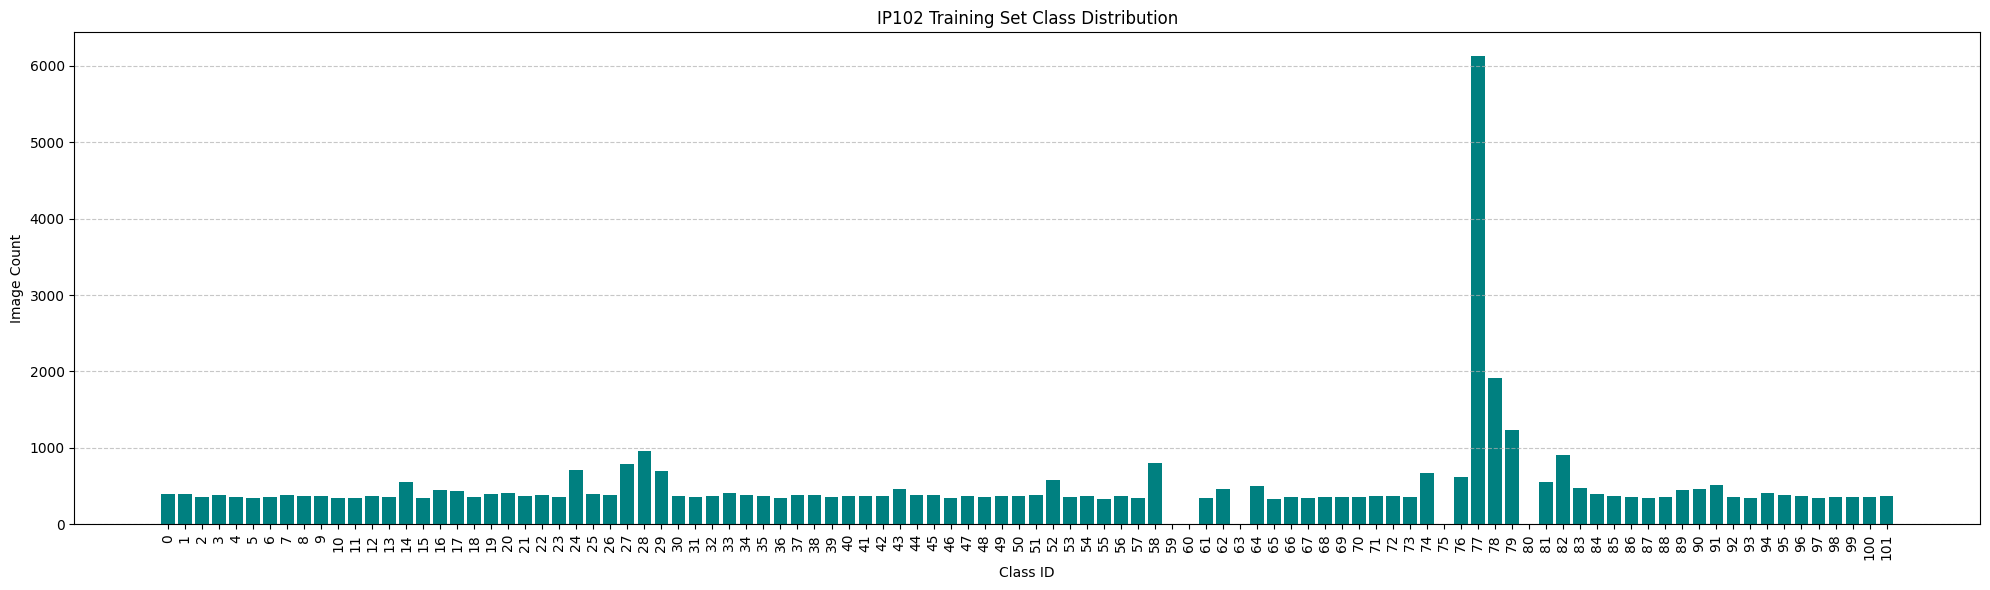

In [4]:
import os
import matplotlib.pyplot as plt
from collections import Counter

label_dir = 'Dataset/output_datasetv2/labels/train'

def count_classes(label_dir):
    class_counter = Counter()
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    class_counter[class_id] += 1
    return class_counter

# Count and plot
counts = count_classes(label_dir)

plt.figure(figsize=(20, 6))
plt.bar(counts.keys(), counts.values(), color='teal')
plt.xlabel('Class ID')
plt.ylabel('Image Count')
plt.title('IP102 Training Set Class Distribution')
plt.xticks(range(min(counts), max(counts) + 1), rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from huggingface_hub import HfFolder

# Replace YOUR_TOKEN_HERE with your real token
HfFolder.save_token("HF TOKEN HERE")


/home/salter/Desktop/project-jumanji/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
